In [8]:
import sys

sys.path.append('/home/jp/anaconda3/envs/opencv-env/lib/python3.8/site-packages')

import os
import glob

#For Images
#import cv2
#import matplotlib.pyplot as plt
import numpy as np

#For checking progress
#from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

ModuleNotFoundError: No module named 'torch'

In [ ]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

def show_data(rows,cols,is_train=True,transform=False):
    if is_train:
        path = '/home/jp/Desktop/archive/dataset/dataset/train/'
    else:
        path = '/home/jp/Desktop/archive/dataset/dataset/test/'
    path = os.path.join(path,'*orange*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

In [ ]:
fig = show_data(5,4, False)
fig.tight_layout()

In [ ]:
fig = show_data(5,4,is_train=False)
fig.tight_layout()

In [ ]:
from PIL import Image



class FruitsDataset(Dataset):
    def __init__(self,path,classifier_type='Rotten',subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        if classifier_type == 'Rotten':
            classes = ['fresh','rotten']
            for fruit in self.data:
                if classes[0] in fruit.split('/')[-2]:
                    self.labels.append(0)
                else:
                    self.labels.append(1)
        else:
            classes = ['apple','banana','orange']
            for fruit in self.data:
                if classes[0] in fruit:
                    self.labels.append(0)
                elif classes[1] in fruit:
                    self.labels.append(1)
                else:
                    self.labels.append(2)
        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(Image.fromarray(img))
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

In [ ]:
transformations = transforms.Compose([                                      
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
dataset = FruitsDataset('/home/jp/Desktop/archive/dataset/dataset/',transforms = transformations)

In [ ]:
print(dataset[2])
img_t, _ = dataset[2]
img = img_t.permute(1,2,0)
plt.imshow(img);

In [2]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

NameError: name 'dataset' is not defined

In [234]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [235]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [236]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [237]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))

model = Net().to(device=device) #was talking about this above
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
  n_epochs = 25,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)


RuntimeError: CUDA error: unspecified launch failure

In [232]:
torch.save(model.state_dict(), 'FreshnessDetector.pt')


RuntimeError: cuda runtime error (719) : unspecified launch failure at /pytorch/torch/csrc/generic/serialization.cpp:31

In [240]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

RuntimeError: CUDA error: unspecified launch failure

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: CUDA error: unspecified launch failure

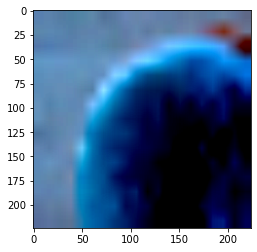

In [241]:
img,label = dataset[1]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [219]:


transformations_test = transforms.Compose([
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   transforms.RandomErasing(),
 ])

test = FruitsDataset('/home/jp/Desktop/archive/dataset/dataset/',subset='test',transforms=transformations_test)
print(len(test))
print(test[0])

791
(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..

In [223]:

import time

start_time = time.time()
count=0
for img,_ in test:
    #plt.imshow(img.permute(1,2,0))
    count = count + 1
    print(count)
    s = nn.Softmax(dim=1)
    out = s(model(img.unsqueeze(0).to(device)))
    #print('Prediction: {}'.format(out))

    _,predicted = torch.max(out,dim=1)

    if(predicted.data.cpu().numpy()[0]==1):
        print('LARANJA PODRE')
    if(predicted.data.cpu().numpy()[0]==0):
        print('LARANJA BOA')
    

print("--- %s seconds ---" % (time.time() - start_time))

1
LARANJA PODRE
2
LARANJA BOA
3
LARANJA PODRE
4
LARANJA PODRE
5
LARANJA BOA
6
LARANJA BOA
7
LARANJA PODRE
8
LARANJA BOA
9
LARANJA PODRE
10
LARANJA PODRE
11
LARANJA PODRE
12
LARANJA PODRE
13
LARANJA PODRE
14
LARANJA PODRE
15
LARANJA PODRE
16
LARANJA PODRE
17
LARANJA PODRE
18
LARANJA BOA
19
LARANJA PODRE
20
LARANJA BOA
21
LARANJA PODRE
22
LARANJA BOA
23
LARANJA PODRE
24
LARANJA PODRE
25
LARANJA PODRE
26
LARANJA PODRE
27
LARANJA PODRE
28
LARANJA PODRE
29
LARANJA PODRE
30
LARANJA PODRE
31
LARANJA PODRE
32
LARANJA BOA
33
LARANJA PODRE
34
LARANJA BOA
35
LARANJA PODRE
36
LARANJA PODRE
37
LARANJA BOA
38
LARANJA PODRE
39
LARANJA PODRE
40
LARANJA BOA
41
LARANJA BOA
42
LARANJA PODRE
43
LARANJA PODRE
44
LARANJA PODRE
45
LARANJA PODRE
46
LARANJA BOA
47
LARANJA PODRE
48
LARANJA PODRE
49
LARANJA PODRE
50
LARANJA BOA
51
LARANJA PODRE
52
LARANJA BOA
53
LARANJA PODRE
54
LARANJA PODRE
55
LARANJA BOA
56
LARANJA PODRE
57
LARANJA PODRE
58
LARANJA PODRE
59
LARANJA BOA
60
LARANJA PODRE
61
LARANJA PODRE
62
LAR

521
LARANJA BOA
522
LARANJA PODRE
523
LARANJA BOA
524
LARANJA BOA
525
LARANJA BOA
526
LARANJA PODRE
527
LARANJA BOA
528
LARANJA BOA
529
LARANJA BOA
530
LARANJA BOA
531
LARANJA BOA
532
LARANJA BOA
533
LARANJA BOA
534
LARANJA BOA
535
LARANJA BOA
536
LARANJA BOA
537
LARANJA BOA
538
LARANJA BOA
539
LARANJA BOA
540
LARANJA PODRE
541
LARANJA BOA
542
LARANJA BOA
543
LARANJA PODRE
544
LARANJA PODRE
545
LARANJA BOA
546
LARANJA BOA
547
LARANJA BOA
548
LARANJA BOA
549
LARANJA BOA
550
LARANJA BOA
551
LARANJA BOA
552
LARANJA BOA
553
LARANJA BOA
554
LARANJA PODRE
555
LARANJA PODRE
556
LARANJA BOA
557
LARANJA BOA
558
LARANJA BOA
559
LARANJA BOA
560
LARANJA BOA
561
LARANJA BOA
562
LARANJA PODRE
563
LARANJA PODRE
564
LARANJA BOA
565
LARANJA BOA
566
LARANJA BOA
567
LARANJA BOA
568
LARANJA BOA
569
LARANJA BOA
570
LARANJA BOA
571
LARANJA BOA
572
LARANJA PODRE
573
LARANJA BOA
574
LARANJA PODRE
575
LARANJA BOA
576
LARANJA BOA
577
LARANJA PODRE
578
LARANJA BOA
579
LARANJA BOA
580
LARANJA BOA
581
LARANJA BOA


## correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    print(labels)
    correct += int((predicted==labels).sum())
    total += len(labels)

In [81]:
(correct/total)*100


90.52674561045325

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.2457, -0.3169, -0.3407,  ...,  0.0869, -0.1982, -0.0200],
         [ 0.0275,  0.0275,  0.0037,  ..., -0.1863, -0.1625, -0.1150],
         [ 0.2056,  0.2769,  0.0987,  ...,  0.0750, -0.1150, -0.0438],
         ...,
         [-0.2932, -0.3644, -0.2338,  ..., -0.1744,  0.0156,  0.1225],
         [-0.3644, -0.4119, -0.4119,  ..., -0.2457, -0.2100, -0.0556],
         [-0.5069, -0.4594, -0.4357,  ..., -0.3407, -0.2575, -0.0794]],

        [[-0.0367, -0.1510, -0.1852,  ...,  0.2718, -0.0367,  0.1347],
         [ 0.1690,  0.1690,  0.1233,  ..., -0.0367, -0.0024,  0.0547],
         [ 0.3404,  0.4089,  0.2147,  ...,  0.2261,  0.0319,  0.1233],
         ...,
         [-0.1967, -0.2652, -0.1395,  ...,  0.0090,  0.1918,  0.2718],
         [-0.2538, -0.2995, -0.3109,  ..., -0.0710, -0.0595,  0.0890],
         [-0.3909, -0.3566, -0.3109,  ..., -0.1281, -0.1052,  0.0776]],

        [[ 0.1598, -0.0309, -0.0627,  ...,  0.3505,  0.0962,  0.2340],
         [ 0.2551,  0.2551,  0.1916,  ...,  0

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[1, 32, 32, 3] to have 3 channels, but got 32 channels instead

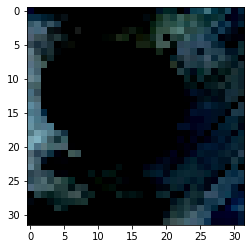

In [111]:
import torch
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path

model = Net().to(device=device) #was talking about this above
checkpoint = torch.load(Path('/home/jp/Desktop/archive/dataset/FreshnessDetector.pt'))
model.load_state_dict(checkpoint)

transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.7321, 0.6322, 0.5291),
                                                           (0.3302, 0.3432, 0.3701))
                                      ])
#image = get_image('/home/jp/Desktop/archive/dataset/testejp.jpeg',False)

img = cv2.imread('/home/jp/Desktop/archive/dataset/testejp.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(32,32))

plt.imshow(img)

img_as_tensor = transformations(img)

print(img_as_tensor)

img = img_as_tensor.permute(1,2,0)
plt.imshow(img)

s = nn.Softmax(dim=1)

out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))